# Load Kinecal Data ELEC872 Project
### Leonard Moen | November 16th 2022

In [38]:
import pandas as pd
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize, LabelEncoder #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, plot_roc_curve

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)



<module 'models' from 'c:\\Users\\camb7\\Code Repositories\\KINECAL Balance Assessment\\KINECAL-Balance-Assessment\\models.py'>

In [39]:
user = User.CD
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0],user) 
QSOpenDf = readKinecalFiles(excerciseList[1],user) 
SemiTandemDf = readKinecalFiles(excerciseList[2],user) 
TandemDf = readKinecalFiles(excerciseList[3],user) 



### Seperate X and Y Dataframes

In [40]:
yDf = QSClosedDf.iloc[:,0:9]
yDf = yDf.drop(columns='movement')

QSClosedXDf =QSClosedDf.iloc[: ,9:-1]
QSOpenXDf =QSOpenDf.iloc[: ,9:-1]
SemiTandemXDf =SemiTandemDf.iloc[: ,9:-1]
TandemXDf =TandemDf.iloc[: ,9:-1]

print(yDf)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
0       10    HA   m    1.85    77.0  22.5                   1   
1      100    NF   f    1.55    82.5  34.3                   1   
2       11    HA   f    1.57    51.5  20.9                   1   
3       12    HA   m    1.64    68.5  25.5                   1   
4       13    HA   m    1.78    85.0  26.8                   1   
..     ...   ...  ..     ...     ...   ...                 ...   
85      84   FHm   f    1.56    60.0  24.7                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   
87       9    HA   m    1.69    75.0  26.3                   1   
88      92    NF   m    1.83    97.0  29.0                   0   
89      96   FHs   m    1.78    81.2  25.6                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86             

### Replace Missing Data With Mean of That Class

In [41]:
QSClosedXDf = replaceMissingValues(QSClosedXDf,yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf,yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf,yDf)
TandemXDf = replaceMissingValues(TandemXDf,yDf)


[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normalization

In [42]:
#print(np.asarray(QS_Closed_x_df.iloc[0,:].values))
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [43]:
print(QSClosedXNormDf.shape,QSOpenXNormDf.shape,SemiTandemXNormDf.shape,TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf,QSOpenXNormDf,SemiTandemXNormDf,TandemXDf],axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Seperate Into Training and Testing Sets

In [44]:
xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

# labelTrain = label_binarize(yTrain.group, classes = ['HA','NF','FHs','FHm'])
# labelTest = label_binarize(yTest.group, classes = ['HA','NF','FHs','FHm'])
# print(labelTrain)
print(yTest)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
40     400   FHs   f    1.73    66.7  22.3                   0   
22     300    HA   f    1.57    49.8  20.2                   0   
55      48    NF   m    1.70    73.4  25.4                   0   
70      68    NF   f    1.68    69.0  24.4                   0   
0       10    HA   m    1.85    77.0  22.5                   1   
26     304   FHs   f    1.63    60.3  22.7                   0   
39      40   FHs   m    1.90   102.5  28.4                   0   
65      61    NF   m    1.73    65.3  21.8                   0   
10      19    HA   m    1.78    79.0  24.9                   1   
44     404   FHm   f    1.57    63.0  25.6                   0   
81      73    NF   m    1.78    69.8  22.0                   0   
35     313    NF   f    1.73    75.0  25.1                   0   
56       5    HA   m    1.75    70.0  22.9                   1   
86      87   FHs   f    1.60    77.1  30.1                   0   
12      20

### Tune SVM

In [45]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold'
svmModel = tune_svm(xTrain,yTrain.group.values, tuned_parameters, isMulticlass=True, cv=5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 250, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5579910142767285


### Create Optimal SVM Model

In [46]:
clf = svm.SVC(kernel = 'rbf' , C = 250, gamma='scale', probability=True)
clf.fit(xTrain, yTrain.group.values)

y_pred = clf.predict(xTest)


### Create Confusion Matrix and Classification Report

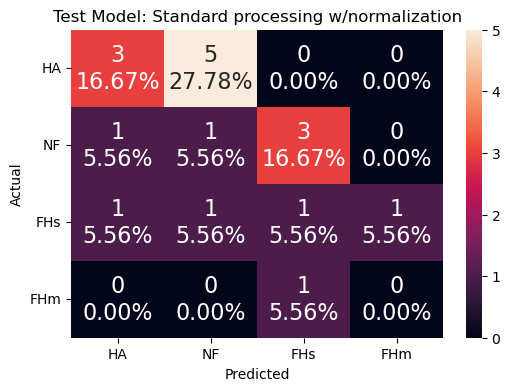

              precision    recall  f1-score   support

         FHm       0.00      0.00      0.00         1
         FHs       0.20      0.25      0.22         4
          HA       0.60      0.38      0.46         8
          NF       0.14      0.20      0.17         5

    accuracy                           0.28        18
   macro avg       0.24      0.21      0.21        18
weighted avg       0.35      0.28      0.30        18



In [47]:
classes = ['HA','NF','FHs','FHm']
cm_python = confusion_matrix(y_true=yTest.group.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTest.group.values, y_pred=y_pred))


### Remap Labels to Be Binary Single Fallers Included as Fallers

In [48]:
yTrainBinary = binaryLabelRemapping(yTrain, True)
yTestBinary = binaryLabelRemapping(yTest, True)

### Tune SVM

In [49]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold_binarylabelsTrue'
svmModel = tune_svm(xTrain,yTrainBinary.label_binary.values, tuned_parameters, isMulticlass=False, cv=5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.8434848484848485


### Train SVM with Optimal Parameters For Binary Labels Single Fallers are Fallers

In [50]:
clf = svm.SVC(kernel = 'rbf' , C = 250, gamma='scale', probability=True)
clf.fit(xTrain, yTrainBinary.label_binary.values)

y_pred = clf.predict(xTest)

#label encode yTestBinary and y_pred
le = LabelEncoder()

y_pred_binary = le.fit_transform(y_pred)
y_test_bin = le.fit_transform(yTestBinary.label_binary.values)

#obtain roc auc score
print(roc_auc_score(y_test_bin, y_pred_binary))


0.48461538461538456


### Create Confusion Matrix For Binary Labels

In [51]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=yTestBinary.label_binary.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)



sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTestBinary.label_binary.values, y_pred=y_pred))


AttributeError: 'numpy.ndarray' object has no attribute 'label_binary'

### Obtain Missclassifications

In [ ]:
missclassifications = yTestBinary.loc[yTestBinary.label_binary!=y_pred]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
40     400   FHs   f    1.73    66.7  22.3                   0   
70      68    NF   f    1.68    69.0  24.4                   0   
39      40   FHs   m    1.90   102.5  28.4                   0   
65      61    NF   m    1.73    65.3  21.8                   0   
44     404   FHm   f    1.57    63.0  25.6                   0   
35     313    NF   f    1.73    75.0  25.1                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   

   clinically_at_risk label_binary  
40                  0       Faller  
70                  0   Non-Faller  
39                  0       Faller  
65                  0   Non-Faller  
44                  0       Faller  
35                  0   Non-Faller  
86                  1       Faller  


### Remap Labels to Be Binary Single Fallers Included as Non-Fallers

In [ ]:
yTrainBinary = binaryLabelRemapping(yTrain, False)
yTestBinary = binaryLabelRemapping(yTest, False)

### Tune SVM

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold_binarylabelsFalse'
svmModel = tune_svm(xTrain,yTrainBinary.label_binary.values, tuned_parameters, isMulticlass=False, cv=5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best score: 0.7673076923076924


### Train SVM with Optimal Parameters Single Fallers Considered Non-Fallers

In [ ]:
clf = svm.SVC(kernel = 'sigmoid' , C = 750, gamma=0.0001, probability=True)
clf.fit(xTrain, yTrainBinary.label_binary.values)

y_pred = clf.predict(xTest)

### Create Confusion Matrix For Binary Labels FHs -> Non-Fallers

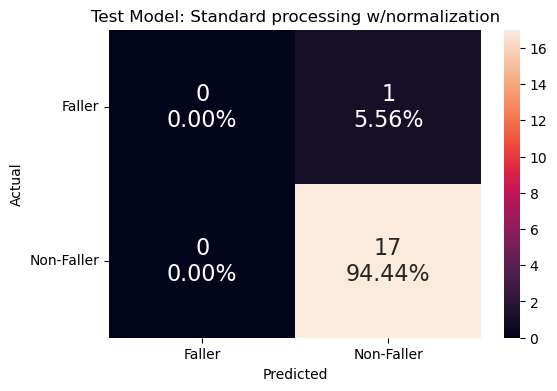

              precision    recall  f1-score   support

      Faller       0.00      0.00      0.00         1
  Non-Faller       0.94      1.00      0.97        17

    accuracy                           0.94        18
   macro avg       0.47      0.50      0.49        18
weighted avg       0.89      0.94      0.92        18



c:\Users\camb7\anaconda3\envs\kba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\camb7\anaconda3\envs\kba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\camb7\anaconda3\envs\kba\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=yTestBinary.label_binary.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTestBinary.label_binary.values, y_pred=y_pred))


### Obtain Missclassifications

In [ ]:
missclassifications = yTestBinary.loc[yTestBinary.label_binary!=y_pred]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
44     404   FHm   f    1.57    63.0  25.6                   0   

   clinically_at_risk label_binary  
44                  0       Faller  
